# Ensembles Bagging
Bagging (Bootstrap Aggregation) and Random Subspace ensembles.  
In `scikit-learn` both of these are implemented using the `BaggingClassifier` object. 
1. Bootstrap sampling
2. Bagging  
    - the impact of diversity
    - stable and unstable classifiers
3. Random Subspace   

This notebook requires the `ensembles-function.py` module and the wine dataset in `wine.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Bootstrap sampling
To illustrate how bootstrap sampling works we:
1. create a numpy array with N entries, (say 1,000)
2. select a sample from this array of size N using sampling with replacement
3. convert this sample to a set to see how many unique entries there are

Typically, ~63% of entries will be selected with many selected multiple times.  
About 37% of entries will not be selected.

In [2]:
N = 1000
data = np.arange(N)
BS = np.random.choice(data, size = N)
BS_unique = set(BS)
len(BS_unique)

631

Load the wine dataset. 

In [3]:
wine_pd = pd.read_csv('Wine.csv')
wine_pd.head()


,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280.2FOD315_of_diluted_wines,class.1,class
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,C1
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,C1
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,C1
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,C1
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,C1


In [4]:
y = wine_pd.pop('class').values
X = wine_pd.values
X.shape

(178, 13)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from ensemble_functions import *
dtree = DecisionTreeClassifier(criterion='entropy')

## Bagging
Ensembles based on Bagging. 
- Train neural net (NN) and *k*-NN ensembles with from 2 - 15 estimators.
 - Works for neural nets
 - Doesn't work for k-NN

In [5]:
# A helper function that will run RepeatedKFold cross validation for a range 
# of ensemble sizes (est_range).
# Takes, the estimator, n_reps and the range as arguments. 
def eval_bag_est_range(the_est, n_reps, est_range, folds = 10):
    n_est_dict = {}
    for n_est in est_range: 
        the_bag = BaggingClassifier(the_est, 
                            n_estimators = n_est,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)
        bag_cv = cross_validate(the_bag, X,y, n_jobs=-1,
                                cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps)) 
        n_est_dict[n_est]=bag_cv['test_score'].mean()
    return n_est_dict

For neural networks and *k*-NN we need to normalise the data using `StandardScaler`.  
We set this up as a pipeline so that we can use it in cross-validation.

In [6]:
kNNpipe  = Pipeline(steps=[ ('classifier', KNeighborsClassifier(n_neighbors=1))])

NNPipe = Pipeline(steps=[  ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2)))])

In [7]:
res_NN_bag = eval_bag_est_range(NNPipe, 10, range(2,16))

NameError: name 'X' is not defined

In [9]:
res_NN_bag

{2: 0.8470915032679737,
 3: 0.9079084967320261,
 4: 0.9381045751633986,
 5: 0.9652941176470589,
 6: 0.9584313725490197,
 7: 0.9587908496732027,
 8: 0.9669281045751633,
 9: 0.9633006535947711,
 10: 0.9668954248366015,
 11: 0.9747712418300654,
 12: 0.9718627450980393,
 13: 0.9730392156862745,
 14: 0.972483660130719,
 15: 0.9762745098039215}

In [10]:
res_kNN_bag  = eval_bag_est_range(kNNpipe, 10, range(2,16))

In [11]:
res_kNN_bag

{2: 0.9449346405228758,
 3: 0.9515359477124182,
 4: 0.9524183006535949,
 5: 0.9550980392156864,
 6: 0.9525490196078431,
 7: 0.9518627450980394,
 8: 0.9535294117647058,
 9: 0.9541176470588236,
 10: 0.9505555555555556,
 11: 0.9511111111111111,
 12: 0.9516666666666665,
 13: 0.9521895424836601,
 14: 0.9537254901960784,
 15: 0.9492483660130717}

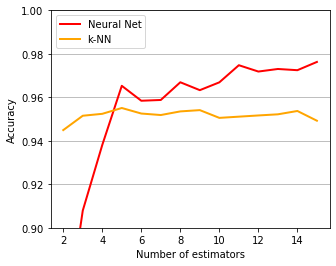

In [18]:
kNN_list = sorted(res_kNN_bag.items()) # sorted by key, return a list of tuples
nc, kNN_accs = zip(*kNN_list) # unpack a list of pairs into two tuples
NN_list = sorted(res_NN_bag.items()) # sorted by key, return a list of tuples
nc, NN_accs = zip(*NN_list) # unpack a list of pairs into two tuples

f = plt.figure(figsize=(5,4))

plt.plot(nc, NN_accs, lw = 2, color = 'r', label = 'Neural Net')
plt.plot(nc, kNN_accs, lw = 2, color = 'orange', label = 'k-NN')

plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.ylim([0.90,1])
plt.legend(loc = 'upper left')
plt.grid(axis = 'y')
f.savefig('bag-est-plot.pdf')

## Comparing estimators (classifiers)
We see that bagging works (improves accuracy) for neural networks and d-trees   
but not for logistic regression, naive Bayes and *k*-NN.

In [13]:
clf_dict = {}
clf_dict['Tree'] = DecisionTreeClassifier(max_leaf_nodes = 6)
clf_dict['Neural Net'] = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                                       hidden_layer_sizes=(5, 2))
clf_dict['Logistic'] = LogisticRegression(solver = 'lbfgs')
clf_dict['k-NN'] = KNeighborsClassifier(n_neighbors=1)
clf_dict['Bayes'] = GaussianNB()

In [14]:
clf_acc = {}
bag_acc = {}
folds, n_reps = 10,10
n_est = 10
v = 0
for c_name in clf_dict.keys():
    pipe  = Pipeline(steps=[
                           ('classifier', clf_dict[c_name])])
    clf_cv = cross_validate(pipe, X, y, n_jobs=-1,
                                    cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))

    the_bag = BaggingClassifier(pipe, 
                            n_estimators = n_est,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)
    bag_cv = cross_validate(the_bag, X, y, n_jobs=-1,
                                    cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))
    
    clf_acc[c_name] = clf_cv['test_score'].mean()
    bag_acc[c_name] = bag_cv['test_score'].mean()
    print("Mean for {:s} {:.2f}".format(c_name, clf_cv['test_score'].mean()))
    print("Mean for {:s} bag {:.2f}".format(c_name, bag_cv['test_score'].mean()))

Mean for Tree 0.89
Mean for Tree bag 0.96
Mean for Neural Net 0.74
Mean for Neural Net bag 0.97
Mean for Logistic 0.98
Mean for Logistic bag 0.98
Mean for k-NN 0.95
Mean for k-NN bag 0.95
Mean for Bayes 0.97
Mean for Bayes bag 0.97


In [19]:
clf_acc

{'Tree': 0.891470588235294,
 'Neural Net': 0.7416666666666667,
 'Logistic': 0.9848366013071894,
 'k-NN': 0.9492483660130719,
 'Bayes': 0.9731045751633987}

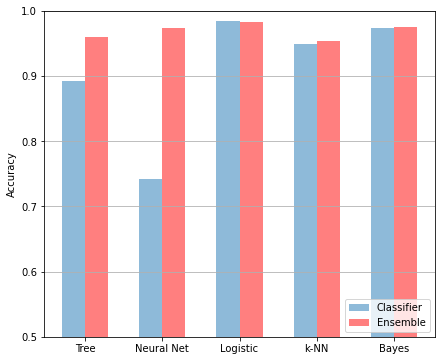

In [20]:
names = clf_dict.keys()
y_pos = np.arange(len(names))
f = plt.figure(figsize=(7,6))
plt.bar(y_pos-0.15, clf_acc.values(), align='center', width = 0.3, alpha=0.5, 
        label = "Classifier")
plt.bar(y_pos+0.15, bag_acc.values(), align='center', color = 'r', width = 0.3, alpha=0.5,
       label = "Ensemble")
plt.xticks(y_pos, names)
plt.ylabel('Accuracy')
#plt.xlabel(x_lab)
#plt.title(title)
plt.ylim((0.5,1))
plt.grid(axis = 'y')
plt.legend(loc = 'lower right')
plt.show()
f.savefig('bag-est-bar.pdf')

## Stability / Diversity
We look at diversity (disagreement) within the ensembles to find an explanation for why bagging sometimes doesn't work.   
We see there is very little disagreement between the *k*-NN estimators. 

In [21]:
# A function to draw colourmaps to show estimator diversity. 
def do_colourmap (matrix, names, title = ' ', **kwargs):
    if 'vmx' in kwargs:    # check that 'reps' is a keyword
        vmax_val = kwargs['vmx']
    else: vmax_val = matrix.max()

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(matrix, cmap = 'gray', vmax= vmax_val)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(names)):
        for j in range(len(names)):
            text = ax.text(j, i, round(matrix[i, j],2), size = 14,
                           ha="center", va="center", color="orange")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()
    return fig

Produce normalised train and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape, X_test.shape

((89, 13), (89, 13))

The ensembles to be considered, one based on neural networks and one using *k*-NN.

In [37]:
stab_dict = {}
n_est=5

NNPipe = Pipeline(steps=[ 
                           ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5,
                                                        hidden_layer_sizes=(5, 2)
                                                       ))])
kNNpipe  = Pipeline(steps=[ 
                           ('classifier', KNeighborsClassifier(n_neighbors=1))])

stab_dict['Neural Net'] = BaggingClassifier(NNPipe,
                            n_estimators = n_est,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)
stab_dict['kNN'] = BaggingClassifier(kNNpipe,
                            n_estimators = n_est,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

In order to look at diversity within the ensembles we access the estimators through the `.estimators_` attribute and manipulate them directly. 
- `get_consensus_prediction` is a function imported from `ensemble_functions.py` that implements majority voting.
- `plain_dis` another function from  `ensemble_functions.py` that calculates the plain disagreement measure for two sets of predictions.

In [38]:
dist_arr_dict = {}
n_est = 5

bag_names = []
for i in range(n_est):
    bag_names.append('Est '+ str(i+1))

clfs = ['kNN','Neural Net' ]
for clf_name in clfs:
    the_bag = stab_dict[clf_name]
    bag_ests = the_bag.fit(X_train,y_train).estimators_
    bag_df = pd.DataFrame() # The data frame where we store the estimator predictions 
    
    # Produce predictions for the estimators on the test set. 
    for i, est in enumerate(bag_ests):
        y_preds = est.predict(X_test)
        bag_df['Est '+ str(i+1)]=y_preds
    bag_df['Consensus'] = get_consensus_prediction(bag_df,bag_df.columns)
    bag_df['Actual'] = y_test
    bag_dis_arr = np.zeros((n_est,n_est))
    for i_ind,i in enumerate(bag_names):
        for j_ind,j in enumerate(bag_names):
            bag_dis_arr[i_ind,j_ind] = plain_dis(bag_df[i],bag_df[j])
    dist_arr_dict[clf_name] = bag_dis_arr

In [40]:
bag_df

,Est 1,Est 2,Est 3,Est 4,Est 5,Consensus,Actual
0,0,0,0,1,0,0,C1
1,0,0,0,1,0,0,C1
2,2,0,2,1,0,2,C3
3,0,0,0,1,0,0,C1
4,1,0,1,1,1,1,C2
...,...,...,...,...,...,...,...
84,2,0,1,1,1,1,C2
85,1,0,2,1,1,1,C1
86,0,0,0,1,1,0,C1
87,2,0,1,1,2,2,C3


In [41]:
print('Max difference in NN Ensemble: %4.3f' % (dist_arr_dict['Neural Net'].max()))
print('Max difference in kNN Ensemble: %4.3f' % (dist_arr_dict['kNN'].max()))
maxv = max(dist_arr_dict['Neural Net'].max(),dist_arr_dict['kNN'].max())
print('Overall max is: %4.3f' % maxv)

Max difference in NN Ensemble: 1.000
Max difference in kNN Ensemble: 0.067
Overall max is: 1.000


A colour map of the disagreement scores for the *k*-NN ensemble.

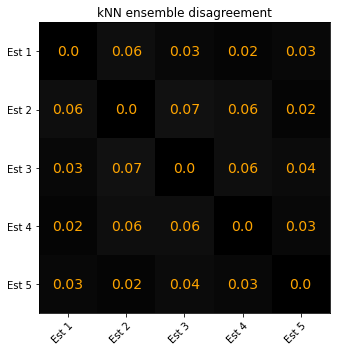

In [42]:
f = do_colourmap(dist_arr_dict['kNN'], bag_names, 
             title = 'kNN ensemble disagreement', vmx = maxv)
f.savefig('kNN-dis-arr.pdf')

Disagreement scores for the neural net ensemble. 

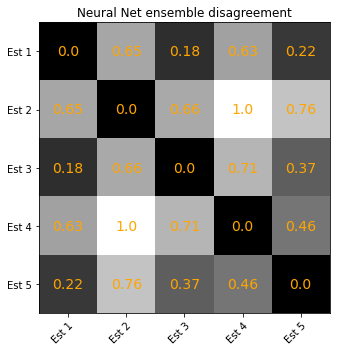

In [43]:
f = do_colourmap(dist_arr_dict['Neural Net'], bag_names, 
             title = 'Neural Net ensemble disagreement', vmx = maxv)
f.savefig('NN-dis-arr.pdf')

## Random Subspace
We see that a random subspace strategy overcomes the diversity/stability problem with *k*-NN.  
The hyper-parameter combination in the second call to `BaggingClassifier` produces a random subspace ensemble.

In [44]:
n_est = 20
kNNpipe  = Pipeline(steps=[ 
                           ('classifier', KNeighborsClassifier(n_neighbors=1))])

kNNbag = BaggingClassifier(kNNpipe,
                            n_estimators = n_est,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

random_SS_kNN = BaggingClassifier(kNNpipe, 
                            n_estimators = n_est,
                            max_samples=1.0, bootstrap = False,
                            max_features=0.5)

In [45]:
kNNbag_cv = cross_validate(kNNbag, X, y, n_jobs=-1,
                        cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))

In [46]:
kNNbag_cv['test_score'].mean()

0.9506209150326796

In [47]:
rSS_cv = cross_validate(random_SS_kNN, X, y, n_jobs=-1,
                        cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))

In [48]:
rSS_cv['test_score'].mean()

0.9776143790849673

## Comparing Random Subspace and Bagging

In [49]:
clf_acc = {}
bag_acc = {}
rs_acc = {}
folds, n_reps = 10,10
n_est = 20
v = 0
clfs = ['Neural Net', 'k-NN']
for c_name in clfs:
    pipe  = Pipeline(steps=[ 
                           ('classifier', clf_dict[c_name])])
    clf_cv = cross_validate(pipe, X, y, n_jobs=-1,
                                    cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))

    the_bag = BaggingClassifier(pipe, 
                            n_estimators = n_est,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)
    bag_cv = cross_validate(the_bag, X, y, n_jobs=-1,
                                    cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))
    random_SS = BaggingClassifier(pipe, 
                            n_estimators = n_est,
                            max_samples=1.0, bootstrap = False,
                            max_features=0.5)
    RS_cv = cross_validate(random_SS, X, y, n_jobs=-1,
                                    cv=RepeatedKFold(n_splits=folds, n_repeats=n_reps))
   
    clf_acc[c_name] = clf_cv['test_score'].mean()
    bag_acc[c_name] = bag_cv['test_score'].mean()
    rs_acc[c_name] = RS_cv['test_score'].mean()

    print("Mean for {:s} {:.2f}".format(c_name, clf_cv['test_score'].mean()))
    print("Mean for {:s} bag {:.2f}".format(c_name, bag_cv['test_score'].mean()))
    print("Mean for {:s} RS {:.2f}".format(c_name, RS_cv['test_score'].mean()))

Mean for Neural Net 0.71
Mean for Neural Net bag 0.98
Mean for Neural Net RS 0.98
Mean for k-NN 0.95
Mean for k-NN bag 0.95
Mean for k-NN RS 0.97


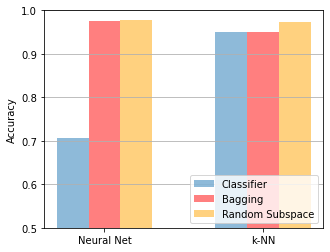

In [50]:
names = clfs
y_pos = np.arange(len(names))
f = plt.figure(figsize=(5,4))
plt.bar(y_pos-0.2, clf_acc.values(), align='center', width = 0.2, alpha=0.5, 
        label = "Classifier")
plt.bar(y_pos, bag_acc.values(), align='center', color = 'r', width = 0.2, alpha=0.5,
       label = "Bagging")
plt.bar(y_pos+0.2, rs_acc.values(), align='center', color = 'orange', width = 0.2, alpha=0.5,
       label = "Random Subspace")


plt.xticks(y_pos, names)
plt.ylabel('Accuracy')
#plt.xlabel(x_lab)
#plt.title(title)
plt.ylim((0.5,1))
plt.grid(axis = 'y')
plt.legend(loc = 'lower right')
plt.show()
f.savefig('RandomSS-bar.pdf')